In [63]:
import os
import pandas as pd

rename_map = {
    # ===== Predict-then-Optimize baselines =====
    "LinearNNSoftmax_softmax_rolling_20251220_0149“maxreturn”": "Softmax-MaxReturn",
    "LinearNNSoftmax_softmax_rolling_20251222_1806“maxsharpe”": "Softmax-MaxSharpe",
    # ===== Robust SPO =====
    "LinearRobustSPO_linear_rolling_20251224_1830”RobustSPO“": "RobustSPO",
    # ===== SPO+ variants =====
    "LinearSPO+_linear_rolling_20251223_1614“markowitzPO”": "PtO Markowitz",
    "LinearSPO+_linear_rolling_20251224_2011“gamma=0.005”": "SPO+ with Fee (γ=0.005)",
    "LinearSPO+_linear_rolling_20251224_2311”gamma=0.005,lambda=0.42“": "SPO+ with turnover penalty(γ=0.005, λ=0.42)",
    # ===== Tuned SPO+ =====
    "LinearSPO+_rolling_optuna_20251220_0037": "SPO+",
}

In [64]:
# ===== 1. 设置你的父目录 =====
ROOT_DIR = r"D:\SPO4Portfolio\outputs"  # ← 改成你的路径

# 用来存每个实验的 nav 序列
nav_dict = {}

# ===== 2. 遍历所有子文件夹 =====
for exp_name in os.listdir(ROOT_DIR):
    exp_path = os.path.join(ROOT_DIR, exp_name)

    if not os.path.isdir(exp_path):
        continue

    csv_path = os.path.join(exp_path, "rolling_performance.csv")

    if not os.path.exists(csv_path):
        continue

    # ===== 3. 读取 rolling_performance.csv =====

    df = pd.read_csv(csv_path)

    # ===== 关键修复：兼容 Date / date =====
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    elif "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
    else:
        raise ValueError(f"{exp_name} 没有 Date/date 列")

    df.index = df.index.normalize()

    # 存入字典（key = 实验名，value = nav Series）
    nav_dict[exp_name] = df["nav"]

BASELINE_DIR = r"D:\SPO4Portfolio\outputs\Baselines"

for fname in ["MaxSharpe.csv"]:
    path = os.path.join(BASELINE_DIR, fname)

    df = pd.read_csv(path)

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
    df.index = df.index.normalize()
    key = os.path.splitext(fname)[0]  # EqualWeight / MaxSharpe
    nav_dict[key] = df["nav"]

# ===== 4. 合并成一个 DataFrame =====
nav_df = pd.concat(nav_dict, axis=1)
nav_df = nav_df.dropna(how="any")
nav_df = nav_df.rename(columns=rename_map)

display(nav_df)  # 如果在 Jupyter Notebook 中运行，可以看到表格

,Softmax-MaxReturn,Softmax-MaxSharpe,RobustSPO,PtO Markowitz,SPO+ with Fee (γ=0.005),"SPO+ with turnover penalty(γ=0.005, λ=0.42)",SPO+,MaxSharpe
2016-01-05,0.990233,1.001032,0.990196,1.002102,0.997398,0.997398,0.997398,0.987873
2016-01-06,0.974395,0.991854,0.974359,0.993761,0.985096,0.985096,0.985096,0.975129
2016-01-07,0.969849,0.980598,0.969834,0.975492,0.955997,0.955997,0.955997,0.956225
2016-01-08,0.965309,0.974594,0.965309,0.968713,0.948427,0.948427,0.948427,0.947443
2016-01-11,0.938950,0.968249,0.938914,0.969817,0.954577,0.954577,0.954577,0.945420
...,...,...,...,...,...,...,...,...
2024-12-23,1.382530,1.112095,2.113545,2.042379,2.271909,1.860000,2.941338,1.751689
2024-12-24,1.386404,1.113168,2.115951,2.052924,2.274494,1.877654,2.944686,1.763514
2024-12-26,1.393685,1.120882,2.117482,2.056054,2.276140,1.876425,2.946816,1.764138
2024-12-27,1.391784,1.122702,2.113108,2.048163,2.271439,1.858949,2.940729,1.752097


In [65]:
import matplotlib.pyplot as plt

style_map = {
    # ----- Baselines (neutral, low attention) -----
    "Equal Weight": {
        "color": "#7f7f7f",  # neutral gray
        "linestyle": "--",
        "linewidth": 1.8,
        "alpha": 0.85,
    },
    "Markowitz (Max Sharpe)": {
        "color": "#8c6d31",  # dark olive / brownish
        "linestyle": "--",
        "linewidth": 1.8,
        "alpha": 0.85,
    },
    # ----- Predict-then-Optimize (cool colors) -----
    "Softmax-MaxReturn": {
        "color": "#1f77b4",  # deep blue
        "linestyle": "-",
        "linewidth": 2.0,
    },
    "Softmax-MaxSharpe": {
        "color": "#17becf",  # cyan (clearly different from blue)
        "linestyle": "-",
        "linewidth": 2.0,
    },
    "PTO Markowitz": {
        "color": "#2ca02c",  # green
        "linestyle": "-",
        "linewidth": 2.0,
    },
    # ----- SPO family (warm / highlight colors) -----
    "SPO+": {
        "color": "#d62728",  # strong red
        "linestyle": "-",
        "linewidth": 2.8,
    },
    "SPO+ with Fee (γ=0.005)": {
        "color": "#9467bd",  # purple
        "linestyle": "-",
        "linewidth": 2.8,
    },
    "SPO+ with turnover penalty (γ=0.005, λ=0.42)": {
        "color": "#e377c2",  # magenta (distinct from purple)
        "linestyle": "-.",
        "linewidth": 2.6,
    },
    "Robust-SPO": {
        "color": "#ff7f0e",  # orange (distinct, warm, visible)
        "linestyle": "-.",
        "linewidth": 2.6,
    },
}

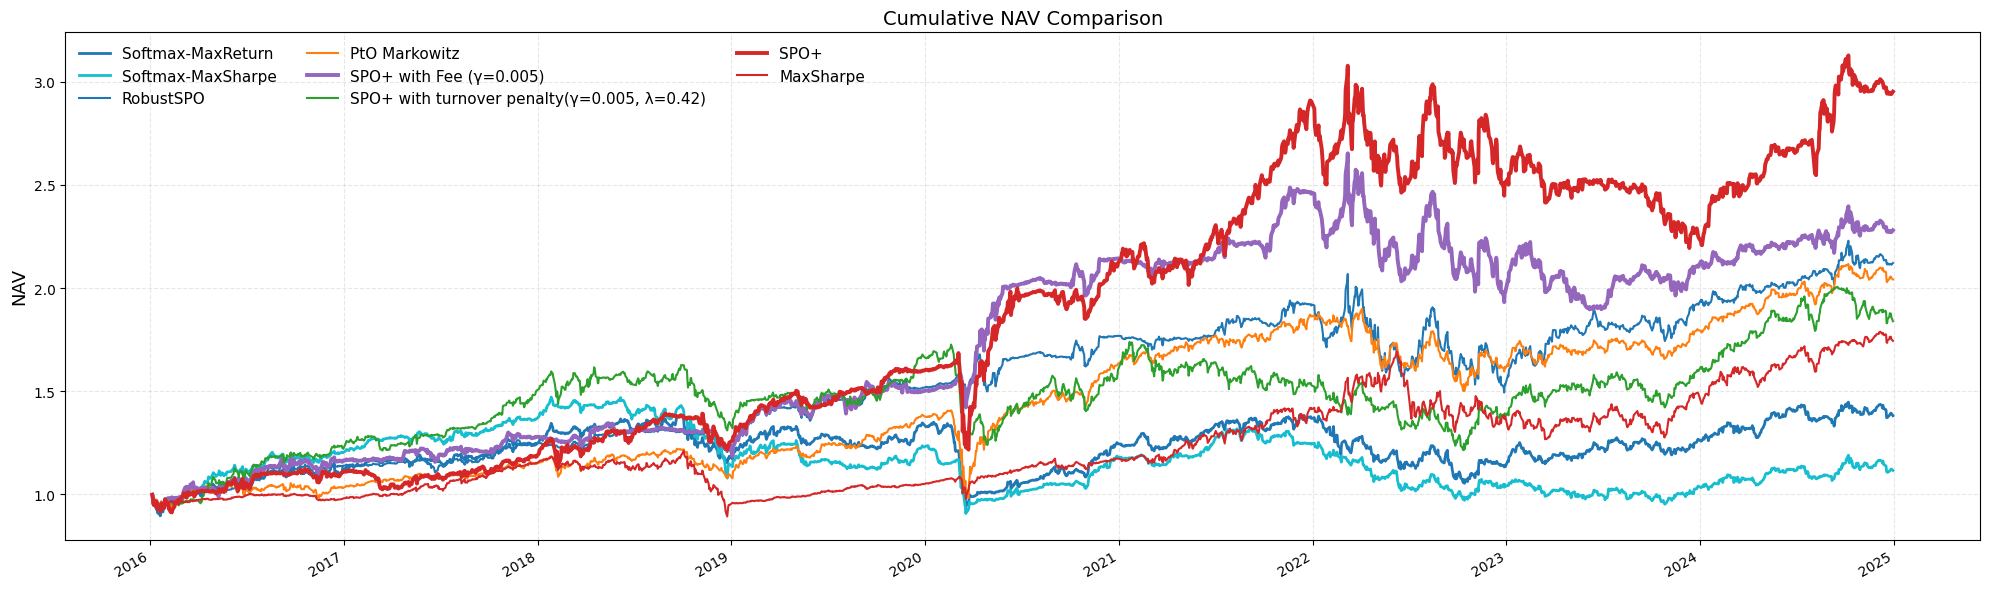

In [66]:
fig, ax = plt.subplots(figsize=(20, 6))

for col in nav_df.columns:
    style = style_map.get(col, {})
    nav_df[col].plot(ax=ax, label=col, **style)

ax.set_ylabel("NAV", fontsize=13)
ax.set_title("Cumulative NAV Comparison", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.3)

ax.legend(ncol=3, fontsize=11, frameon=False, loc="upper left")

plt.tight_layout()
plt.show()